# GKP态理论基础

GKP态是光量子计算中一种特殊的量子态，它的全名是Gottesman-Knill-Preskill (GKP) 码态。这个态是一种量子纠错码，用于量子计算中来保护量子信息免受噪声干扰。这种态的核心思想是将量子信息编码在相空间（通常是位置和动量）中的特定位置，使得即使存在一定的噪声和误差，仍然能够恢复原始信息。在连续变量量子计算中，方形晶格形状的GKP态的Wigner函数由一组狄拉克$\delta$ 函数决定，
$$
W_{\mathrm{gkp}}^{0}(q,p)=\sum_{s,t--\infty}^{\infty}(-1)^{st}\delta\left(p-\frac{s\sqrt{\pi\hbar}}{2}\right)\delta\left(q-l\sqrt{\pi\hbar}\right).
$$
可以看到它是一个规律的离散的分布，在位置正交分量下的GKP 0态和GKP 1态表示如下，
$$\left|k\right\rangle_{\mathrm{gkp}}=\sum_{s=-\infty}^\infty\left|\sqrt{\pi\hbar}(2s+k)\right\rangle_q,k=\{0,1\}$$
使用GKP态编码量子比特，一般的量子态可以表示成
$$|\psi\rangle=\cos\frac{\theta}{2}|0\rangle_{\mathrm{gkp}}+e^{-i\phi}\sin\frac{\theta}{2}|1\rangle_{\mathrm{gkp}}$$
但是在实际模拟中一般会考虑有限能量的GKP态，即作用一个Fock阻尼算符$\hat{E}(\epsilon)$，
$$\hat{E}(\epsilon) = e^{-\epsilon \hat{n}}$$
它等效于很多个高斯波包的叠加，对应的包络也是高斯函数，如下图

<div style="margin-right: 15px; border-radius: 10px; background-color: rgb(255， 255， 255); text-align: center;">
    <img src="./fig/graph1.png" width="30%"/>
    <p style="padding: 10px; font-size: small; text-align: center; line-height: 0%;">
        <b>
    </p>
</div>


文章[1]附录中提出了一种基于压缩猫态有效制备近似GKP态的方法，通过breeding技术将两个峰的猫态作为初态然后经过一个分束器，对其中一个mode做正交分量p测量，那么剩下的一个mode会有纠缠坍缩发生，通过对正交分量q做homodyne测量可以发现坍缩的态是三个峰叠加的非高斯态。

<div style="margin-right: 15px; border-radius: 10px; background-color: rgb(255， 255， 255); text-align: center;">
    <img src="./fig/graph4.png" width="20%"/>
    <p style="padding: 10px; font-size: small; text-align: center; line-height: 0%;">
        <b>
    </p>
</div>

<div style="margin-right: 15px; border-radius: 10px; background-color: rgb(255， 255， 255); text-align: center;">
    <img src="./fig/graph2.png" width="20%"/>
    <p style="padding: 10px; font-size: small; text-align: center; line-height: 0%;">
        <b>
    </p>
</div>

将这个坍缩后的量子态作为两模线路的两个输入再次经过一个分束器，对其中一个mode做正交分量p测量，未被测量的部分将会坍缩成五个峰的非高斯态。依次重复上面的过程可以逐步制备出近似GKP态。

<div style="margin-right: 15px; border-radius: 10px; background-color: rgb(255， 255， 255); text-align: center;">
    <img src="./fig/graph3.png" width="20%"/>
    <p style="padding: 10px; font-size: small; text-align: center; line-height: 0%;">
        <b>
    </p>
</div>

这里对第一次breeding过程做理论分析，
压缩猫态的定义如下
$$|\mathrm{sq.~cat}\rangle\propto\left(\hat{D}(\alpha/2)+\hat{D}(-\alpha/2)\right)\hat{S}(r)|\mathrm{vac}\rangle,$$
它的正交分量q方向波函数是两个高斯分布的叠加
$$\psi_{\mathrm{sq.~cat}}(q)=\langle q|\mathrm{sq.~cat}\rangle\propto\exp\left(-\frac{\left(q-\frac{\alpha}{\sqrt{2}}\right)^2}{2e^{-2r}}\right)+\exp\left(-\frac{\left(q+\frac{\alpha}{\sqrt{2}}\right)^2}{2e^{-2r}}\right),$$
经过一个分束器然后对第二模做正交分量p测量等价于将对应的量子态投影到基矢$\bra{p_2}$ 上，投影的结果为三个高斯态的叠加
$$\int dq_2e^{-ip_mq_2}\Psi(q_1,q_2)\propto e^{-\frac{(q_1+\alpha)^2}{2e^{-2r}}}+2\cos(p_m\alpha)e^{-\frac{q_1^2}{2e^{-2r}}}+e^{-\frac{(q_1-\alpha)^2}{2e^{-2r}}}$$
第一次breeding过程就得到三个峰的非高斯态。


# Breeding过程代码模拟

In [1]:
import deepquantum as dq
import numpy as np
import torch

## 压缩猫态的制备

这里使用Bosonic后端直接制备一个压缩猫态，需要注意的是，和上面压缩猫态理论不同，这里并非先将压缩算符作用到真空态再作用位移算符，而是将压缩算符直接作用到猫态，因此需要将压缩算符和位移算符对易，对易之后位移算符的$\alpha$ 需要更新为 $\frac{\alpha}{2}(cosh(r) + sinh(r))$。

In [140]:
r = 1
alpha = torch.tensor(2, dtype=torch.double)
alpha_prime = (np.cosh(r)+np.sinh(r)) * alpha/2 # r和d的对易关系
print(alpha_prime)
cir = dq.QumodeCircuit(nmode=1, init_state='vac', cutoff=3, backend='bosonic')
cir.cat(wires=0, r=alpha_prime, theta=0, p=0) # plus cat state
cir.s(0, r)
cir.to(torch.double)
re = cir()
s = dq.BosonicState(state=re, nmode=1) # squeezed plus cat state

tensor(2.7183, dtype=torch.float64)


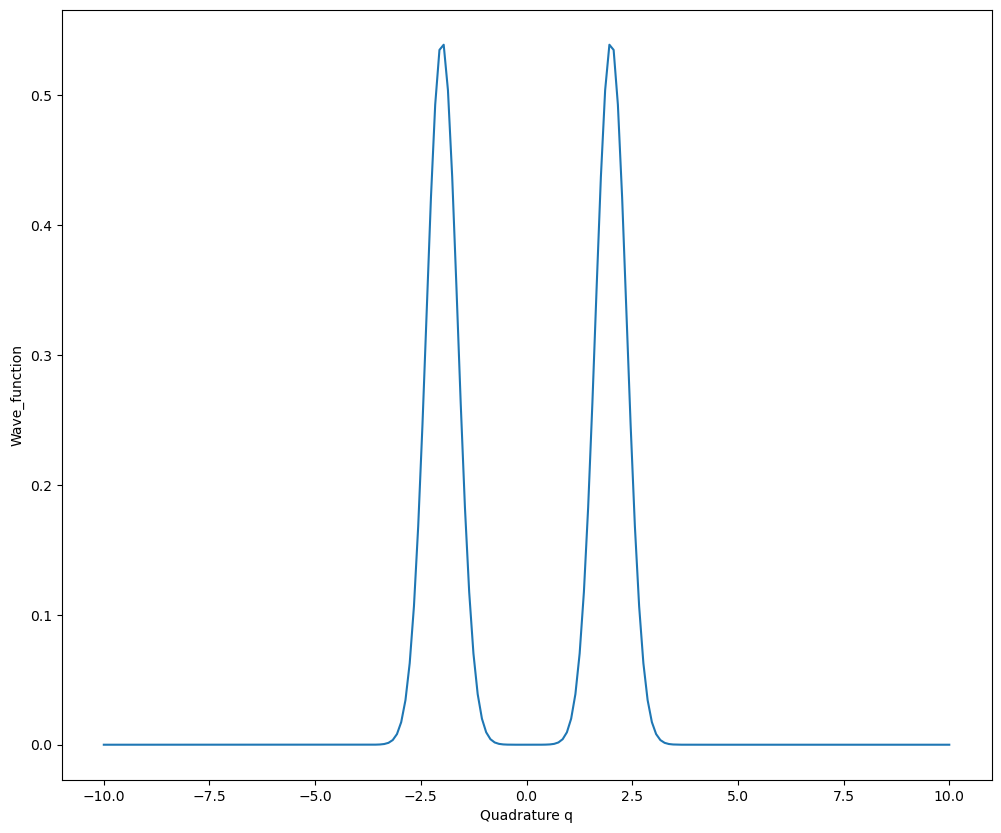

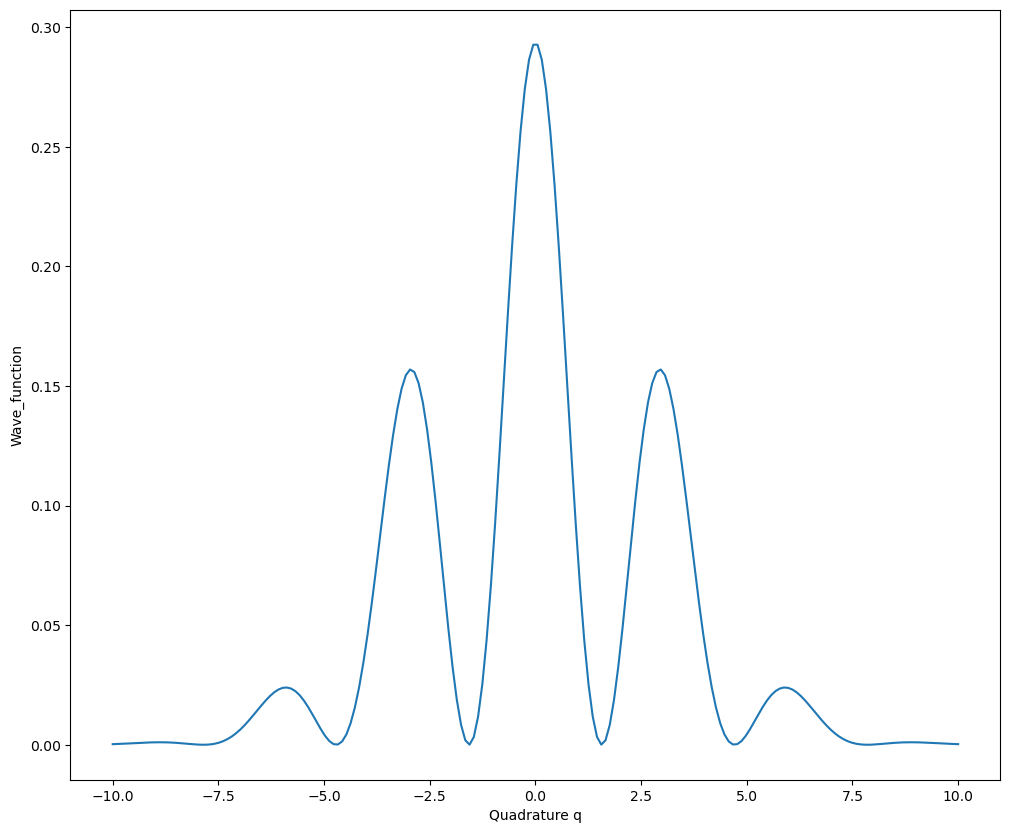

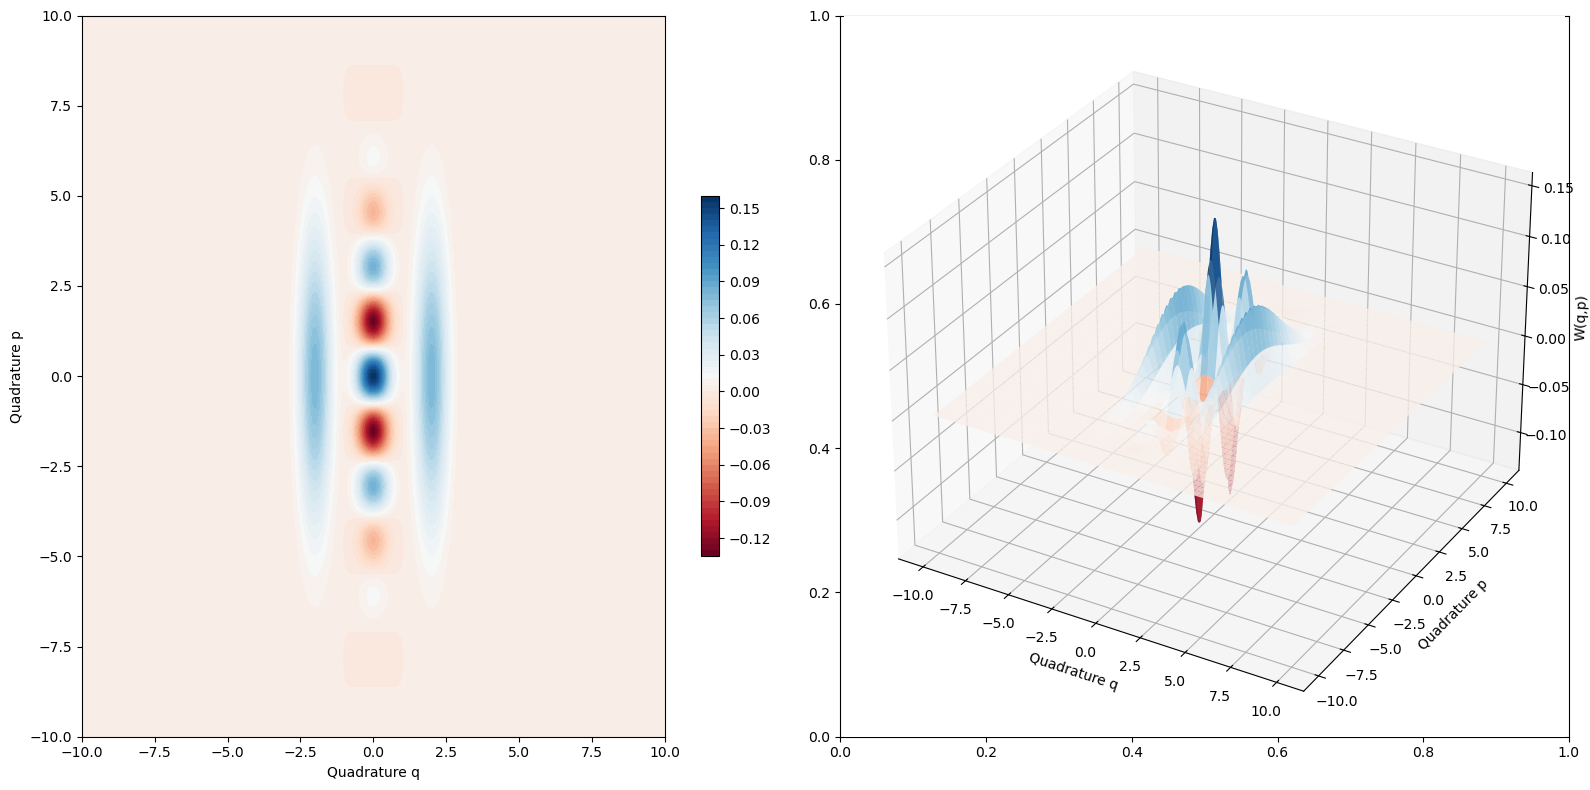

In [141]:
qrange = 10
prange = 10
npoints = 500
marginal_q =s.marginal(wire=0, phi=0, qrange=qrange)
marginal_p = s.marginal(wire=0, phi=np.pi/2, qrange=prange)
wigner = s.wigner(wire=0, qrange=qrange, prange=prange)

## 第一次breeding

将上面的压缩猫态作为两模线路的初态，经过一个50:50的分束器，然后对第一模做正交分量p方向的homodyne测量，第二模会纠缠坍缩并且在正交分量q方向出现三个峰。

In [127]:
r = 1.5
alpha = torch.tensor(2, dtype=torch.double)
alpha_prime = (np.cosh(r)+np.sinh(r)) * alpha/2
cir = dq.QumodeCircuit(nmode=2, init_state='vac', cutoff=3, backend='bosonic')
cir.cat(wires=0, r=alpha_prime, theta=0, p=0) # plus cat state
cir.cat(wires=1, r=alpha_prime, theta=0, p=0) # plus cat state
cir.s(0, r)
cir.s(1, r)
cir.bs(wires=[0,1], inputs=[np.pi/4, 0])
cir.homodyne_p(wires=0)
cir.to(torch.double)
re = cir()
sample = cir.measure_homodyne(shots=5000)
# sample

In [128]:
cir.draw()

这里为了可重复性，可以挑选出测量值为0的结果

In [129]:
for i in range(len(sample)):
    if abs(sample[i]) < 0.001:
        k = i
        print(i, sample[i])

851 tensor(-0.0005, dtype=torch.float64)
1536 tensor(-0.0008, dtype=torch.float64)


通过`cir.state_measured`可以得到测量坍缩后的完整量子态，这里我们只需要做偏迹操作提取第二模的量子态然后验证。

In [130]:
state_bos = cir.state_measured
idx = torch.tensor([1,3])
s = [state_bos[0][k][...,idx[:, None], idx], state_bos[1][k][...,idx, :], state_bos[2][k]]
collapse_s = dq.BosonicState(s, nmode=1)

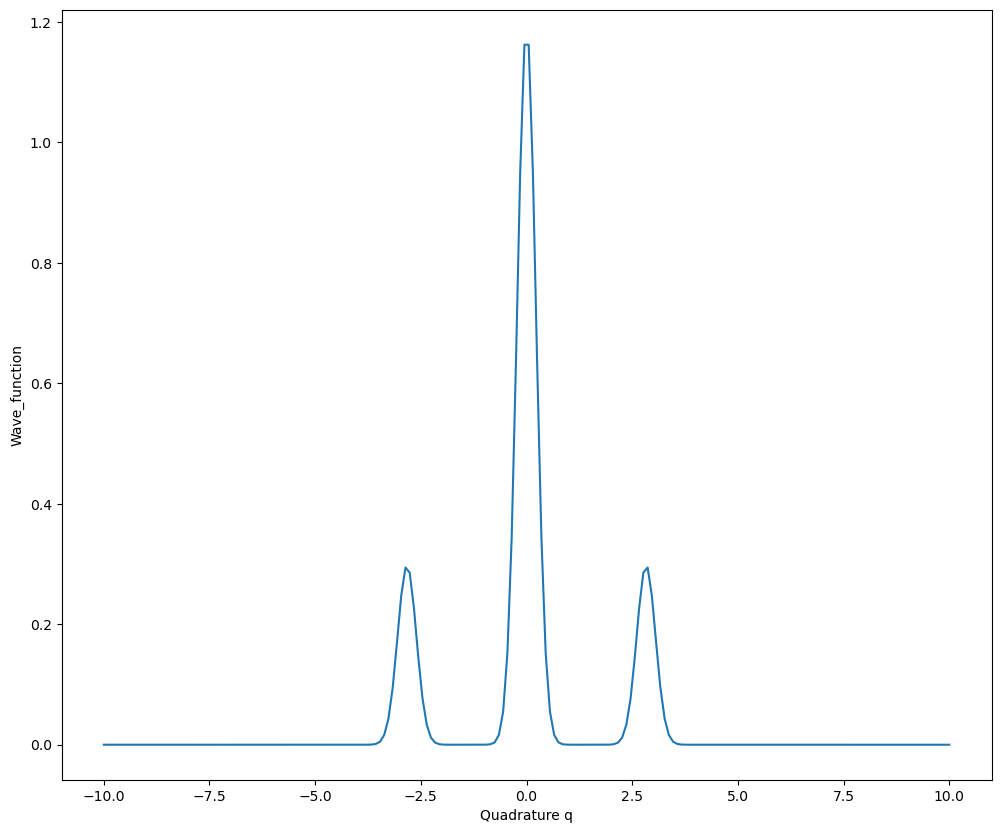

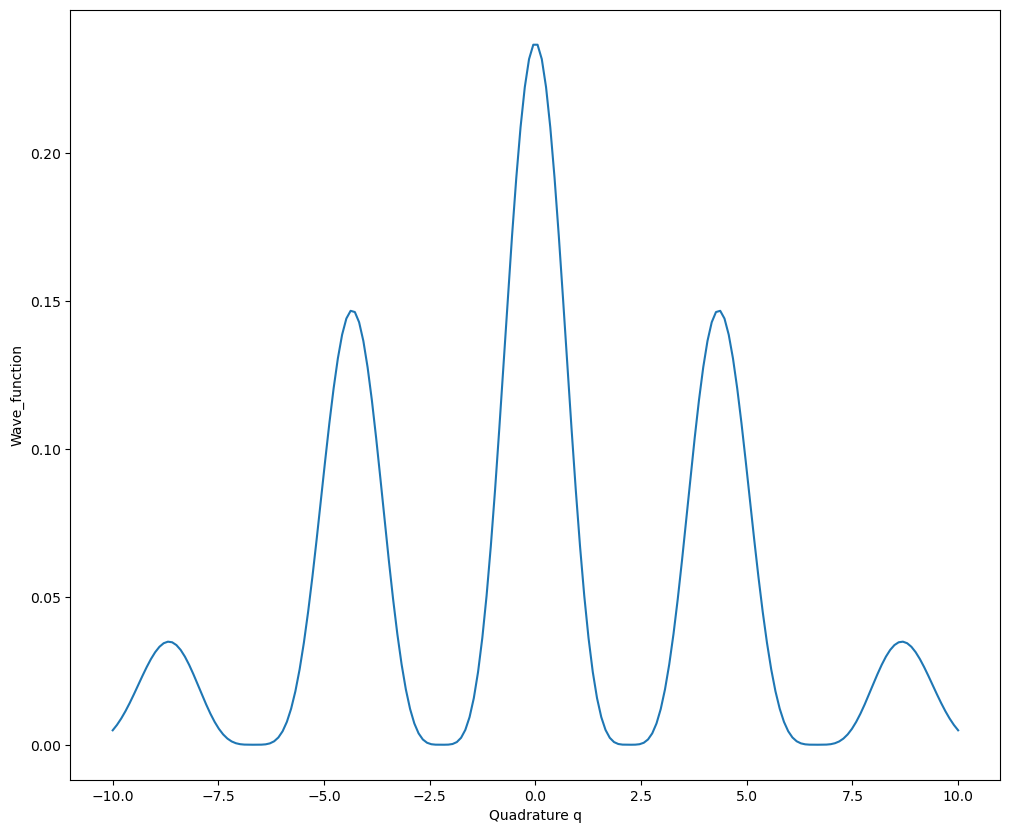

In [131]:
qrange = 10
prange = 10
marginal_q1 = collapse_s.marginal(wire=0, phi=0, qrange=qrange)
marginal_p1 = collapse_s.marginal(wire=0, phi=np.pi/2, qrange=prange)

可以从下面的wigner函数看出这里非高斯态已经出现了类似gkp态的图像

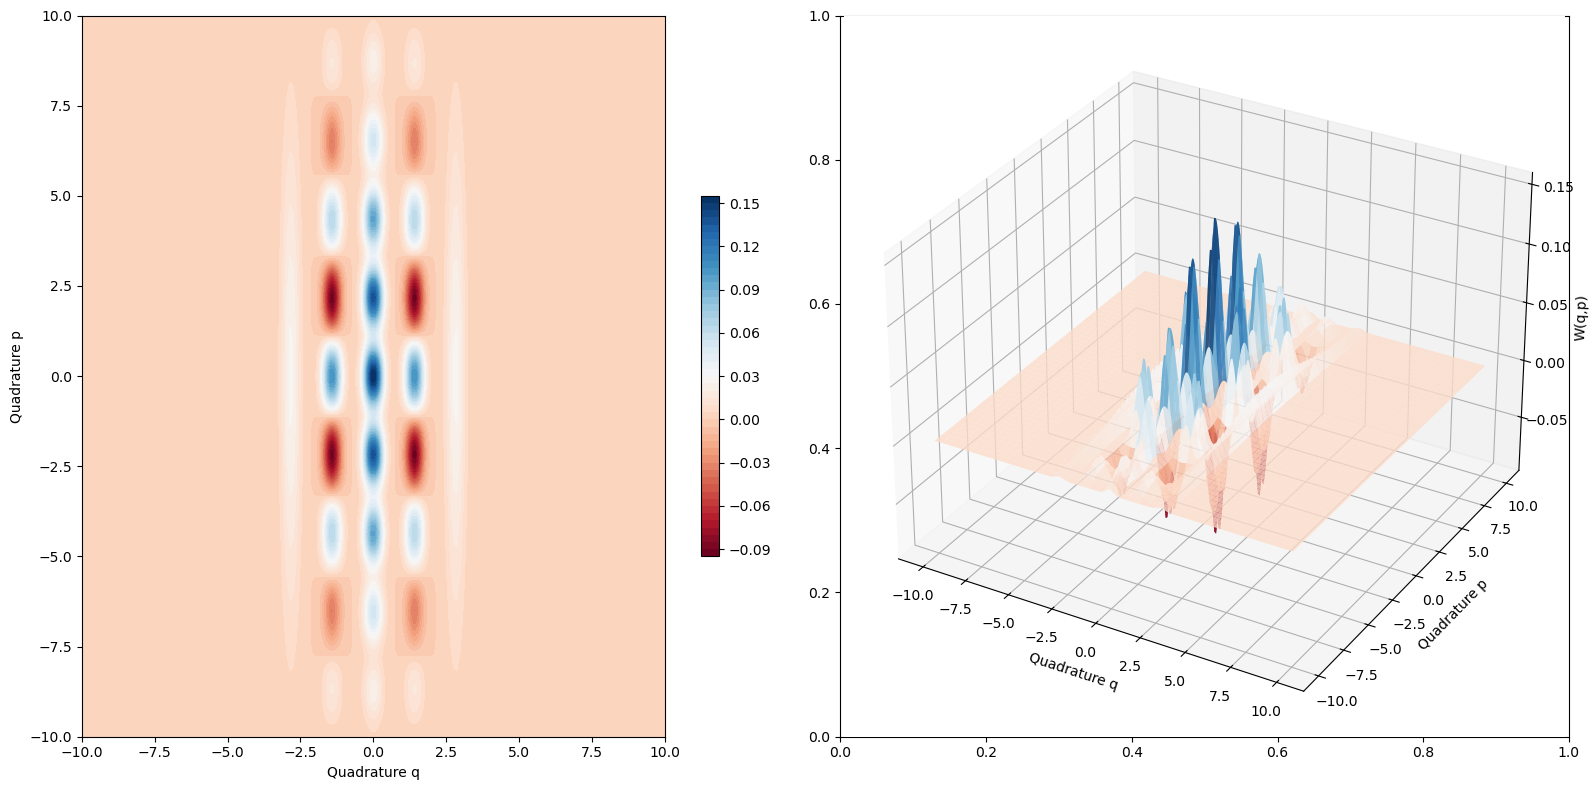

In [132]:
wigner = collapse_s.wigner(wire=0, qrange=qrange, prange=prange)

## 第二次breeding

类似的，将第一次breeding之后测量坍缩的结果作为两模线路的两个输入，经过一个50:50的分束器，然后对第一模做正交分量p方向的homodyne测量，第二模会纠缠坍缩并且在正交分量q方向出现五个峰。

In [133]:
cir2 = dq.QumodeCircuit(nmode=2, init_state=[collapse_s, collapse_s], cutoff=3, backend='bosonic')
cir2.bs(wires=[0,1], inputs=[np.pi/4, 0.])
cir2.homodyne_p(wires=0)
cir2.to(torch.double)
re = cir2()
sample2 = cir2.measure_homodyne(shots=1000)

In [134]:
for i in range(len(sample2)):
    if abs(sample2[i]-0) < 0.002:
        k = i
        print(i, sample2[i])

112 tensor(0.0003, dtype=torch.float64)


通过`cir.state_measured`可以得到测量坍缩后的完整量子态，这里我们只需要做偏迹操作提取第二模的量子态然后验证。

In [135]:
state_bos2 = cir2.state_measured
idx = torch.tensor([1,3])
s2 = [state_bos2[0][k][...,idx[:, None], idx], state_bos2[1][k][...,idx, :], state_bos2[2][k]]
collapse_s2 = dq.BosonicState(s2, nmode=1)

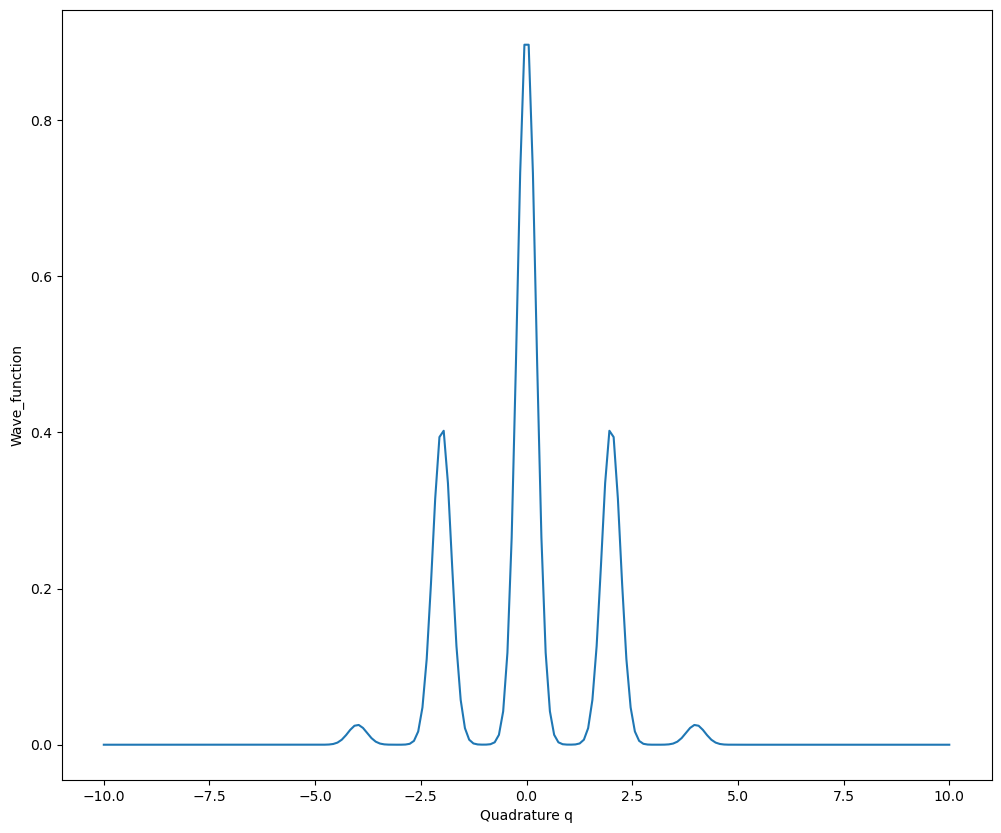

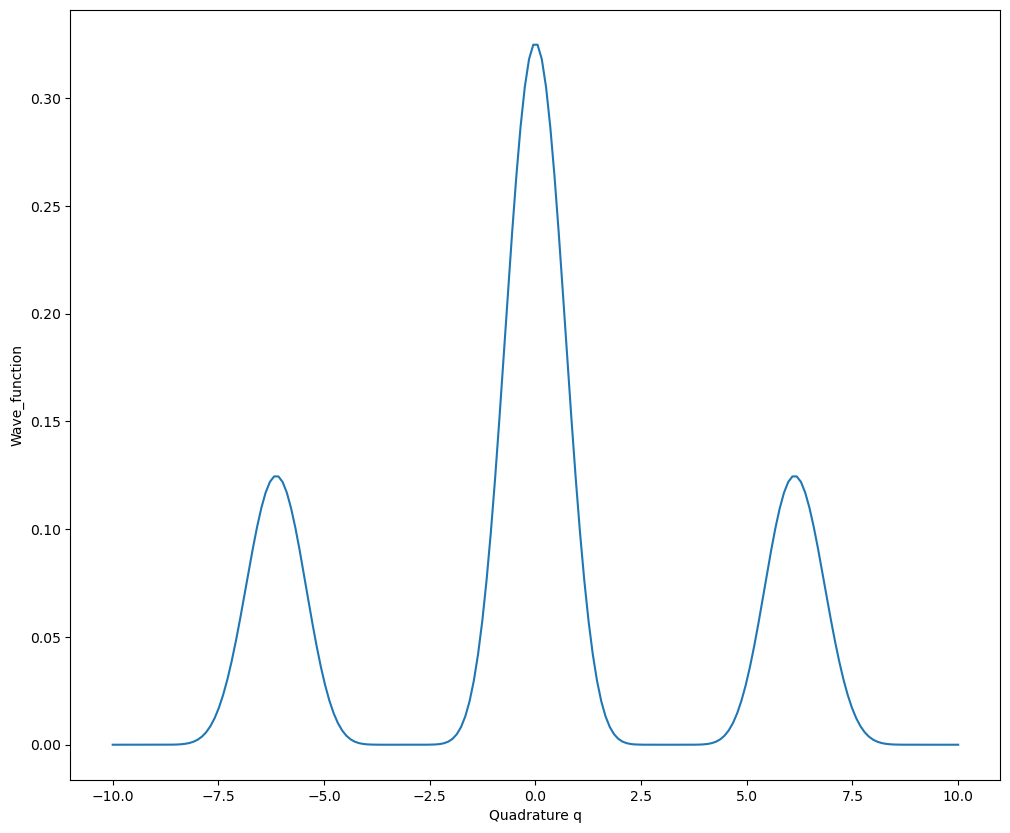

In [136]:
qrange = 10
prange = 10
marginal_q2 = collapse_s2.marginal(wire=0, phi=0, qrange=qrange)
marginal_p2 = collapse_s2.marginal(wire=0, phi=np.pi/2, qrange=prange)

通过wigner函数的图像可以看到第二次breeding之后的量子态更接近gkp态

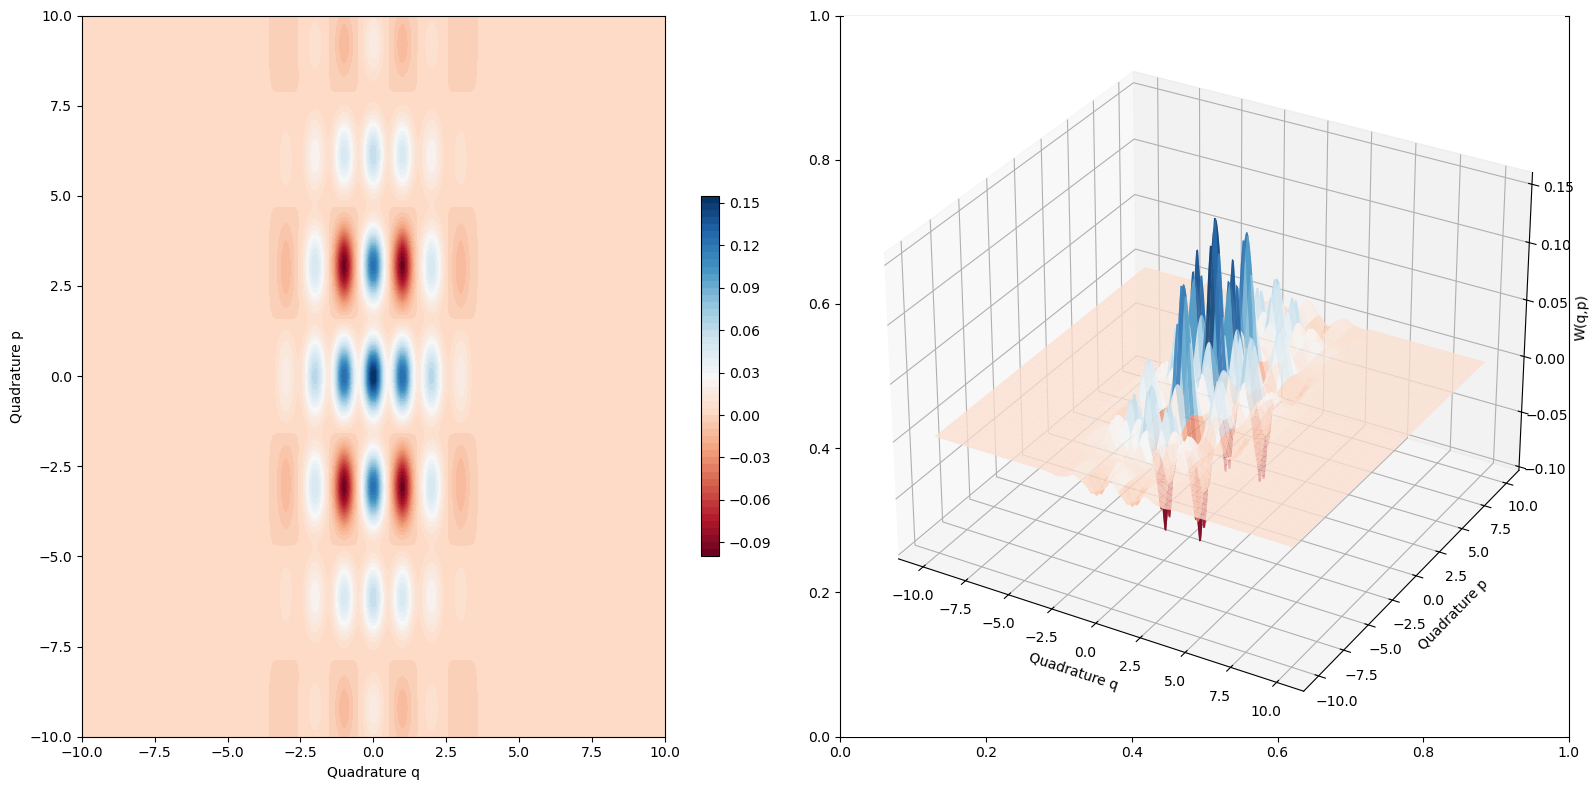

In [137]:
wigner = collapse_s2.wigner(wire=0, qrange=qrange, prange=prange)

# 参考文献

[1] Aghaee Rad H, Ainsworth T, Alexander R N, et al. Scaling and networking a modular photonic quantum computer[J]. Nature, 2025: 1-8.